In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/MyDrive/SkillFactory/DS_ML_data/'

In [2]:
PATH = './data/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# 1. Data upload

In [4]:
events = pd.read_csv(PATH + 'events.csv')
category_tree = pd.read_csv(PATH + 'category_tree.csv')
item_1 = pd.read_csv(PATH + 'item_properties_part1.csv')
item_2 = pd.read_csv(PATH + 'item_properties_part2.csv')
item_properties = pd.concat([item_1, item_2], ignore_index=True)


## Deascription of features of uploaded datasets

* ### events — датасет с событиями

* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

* ### category_tree — файл с деревом категорий

* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

* ### item_properties — файл с свойствами товаров

* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

# 2. EDA

In [5]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
    
def files_info(df):
    print(f' {get_df_name(df)} contains {df.shape[0]} entries')
    display(df.head(3))
    display(df.info())
    display(df.isnull().sum())
    display(df.describe().T)

## events

In [6]:
files_info(events)

 events contains 2756101 entries


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


None

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

,count,mean,std,min,25%,50%,75%,max
timestamp,2756101.0,1.436424e+12,3.366312e+09,1.430622e+12,1.433478e+12,1.436453e+12,1.439225e+12,1.442545e+12
visitorid,2756101.0,7.019229e+05,4.056875e+05,0.000000e+00,3.505660e+05,7.020600e+05,1.053437e+06,1.407579e+06
itemid,2756101.0,2.349225e+05,1.341954e+05,3.000000e+00,1.181200e+05,2.360670e+05,3.507150e+05,4.668670e+05
transactionid,22457.0,8.826498e+03,5.098996e+03,0.000000e+00,4.411000e+03,8.813000e+03,1.322400e+04,1.767100e+04


In [7]:
#check duplicates
events.duplicated(['timestamp','visitorid','event','itemid']).sum()

460

In [8]:
#drop duplicates
events = events.loc[~events.duplicated(['timestamp','visitorid','event','itemid'])]

view           2664218
addtocart        68966
transaction      22457
Name: event, dtype: int64


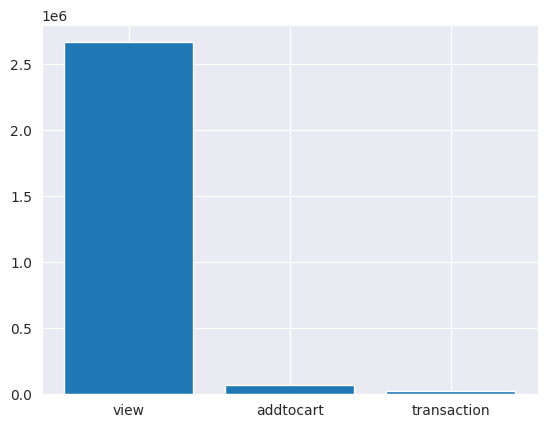

In [9]:
events_count = events.event.value_counts()
plt.bar(events_count.index,events_count.values)
print(events_count)

In [10]:
#Change unix time format to datatime format
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
events.drop('timestamp', axis=1, inplace=True)

print(f'The dataset contains the entries from {events.datetime.min()} up to {events.datetime.max()}')

The dataset contains the entries from 2015-05-03 03:00:04.384000 up to 2015-09-18 02:59:47.788000


In [11]:
#Top 10 users
events.visitorid.value_counts()[:10]

/tmp/ipykernel_28619/741517605.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  events.visitorid.value_counts()[:10]


1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
Name: visitorid, dtype: int64

In [12]:
#Featue 'events'
events.event.value_counts() 

view           2664218
addtocart        68966
transaction      22457
Name: event, dtype: int64

In [13]:
events['event'] = events.event.replace('view', 'viewed')#avoid to call standard view() function

In [14]:
#grouped events by items
grouped_events_items = events.groupby('event')['itemid'].apply(list)
grouped_events_items

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
viewed         [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

In [15]:
import collections

# most viewed, most added to basket, most bought items. Top 10 Items in each cat.
most_viewed = dict(collections.Counter(grouped_events_items.viewed).most_common()[:10])
most_added = dict(collections.Counter(grouped_events_items.addtocart).most_common()[:10])
most_bought = dict(collections.Counter(grouped_events_items.transaction).most_common()[:10])

In [16]:
def top_10_plot(dct):
  items = list(dct.keys())
  values = list(dct.values())
  plt.figure(figsize=(8, 5))
  plt.bar(range(len(dct)),values,tick_label=items)
  display(dct)

{187946: 3410,
 461686: 2538,
 5411: 2325,
 370653: 1854,
 219512: 1740,
 298009: 1642,
 96924: 1633,
 309778: 1565,
 257040: 1531,
 384302: 1528}

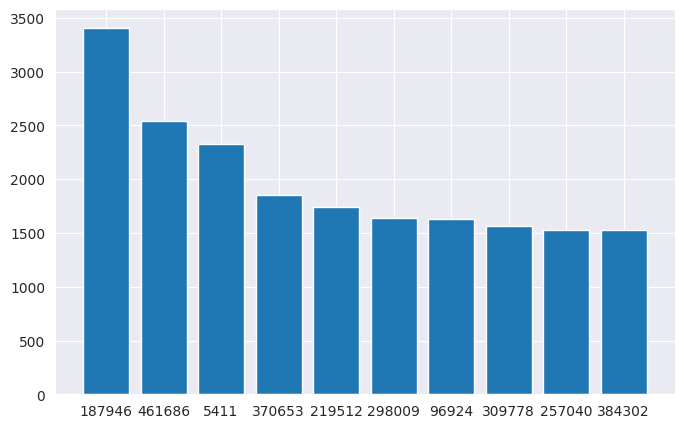

In [17]:
top_10_plot(most_viewed)

{461686: 304,
 312728: 161,
 409804: 152,
 320130: 141,
 29196: 135,
 7943: 97,
 48030: 95,
 441852: 90,
 445351: 89,
 257040: 89}

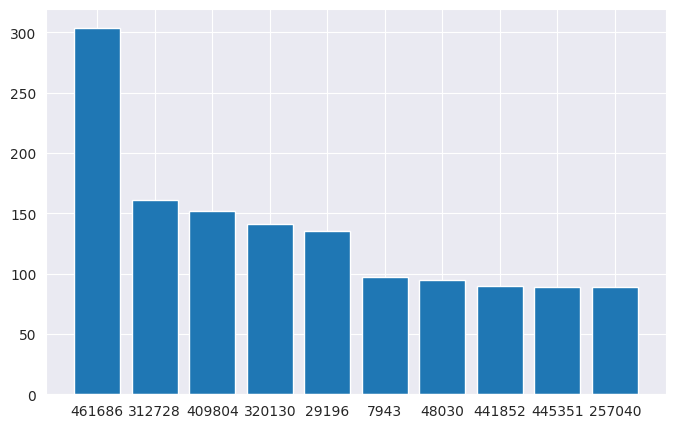

In [18]:
top_10_plot(most_added)

{461686: 133,
 119736: 97,
 213834: 92,
 7943: 46,
 312728: 46,
 445351: 45,
 48030: 41,
 420960: 38,
 248455: 38,
 17478: 37}

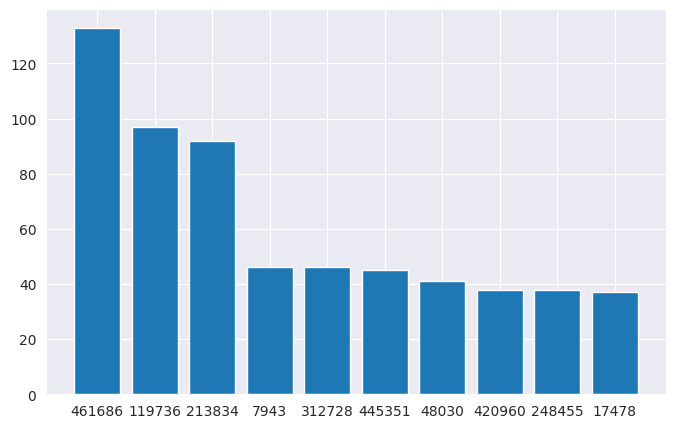

In [19]:
top_10_plot(most_bought)

In [20]:
# Top 10 items
events.itemid.value_counts()[:10]

/tmp/ipykernel_28619/790002701.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  events.itemid.value_counts()[:10]


187946    3412
461686    2975
5411      2334
370653    1854
219512    1800
257040    1647
298009    1642
96924     1633
309778    1628
384302    1608
Name: itemid, dtype: int64

<AxesSubplot: >

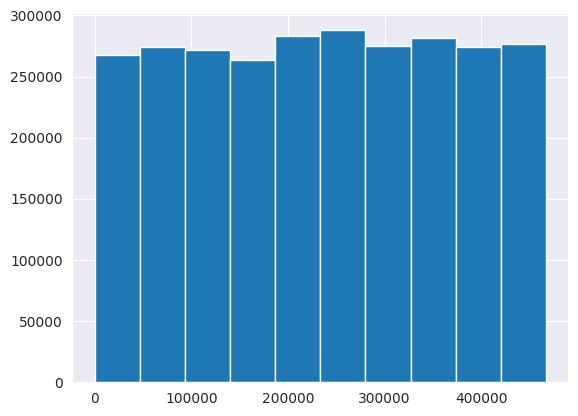

In [21]:
events.itemid.hist()

In [22]:
len(events.transactionid)

2755641

In [23]:
bought_items = events.loc[events.event == 'transaction']
bought_items.head(3)

,visitorid,event,itemid,transactionid,datetime
130,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276
304,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981
418,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008


In [24]:
#Number of unique items (count unique itemid)
events["itemid"].unique().shape

(235061,)

In [25]:
events.transactionid.fillna('0', inplace = True)

### category_tree

In [26]:
files_info(category_tree)

 category_tree contains 1669 entries


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


None

categoryid     0
parentid      25
dtype: int64

,count,mean,std,min,25%,50%,75%,max
categoryid,1669.0,849.285201,490.195116,0.0,427.0,848.0,1273.0,1698.0
parentid,1644.0,847.571168,505.058485,8.0,381.0,866.0,1291.0,1698.0


### item_properties

In [27]:
files_info(item_properties)

 item_properties contains 20275902 entries


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


None

timestamp    0
itemid       0
property     0
value        0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
timestamp,20275902.0,1.435157e+12,3.327798e+09,1.431227e+12,1.432436e+12,1.433646e+12,1.437880e+12,1.442113e+12
itemid,20275902.0,2.333904e+05,1.348452e+05,0.000000e+00,1.165160e+05,2.334830e+05,3.503040e+05,4.668660e+05


In [28]:
item_properties.duplicated(['itemid', 'property']).sum()# check the duplicates

8272088

In [29]:
item_properties = item_properties.loc[~item_properties.duplicated(['itemid', 'property'])]# drop the duplicates

In [30]:
item_properties.drop(['timestamp', 'value'], axis=1, inplace=True) #drop useless features
#item_properties.set_index("itemid", inplace = True)

In [31]:
item_properties.head(3)

,itemid,property
0,460429,categoryid
1,206783,888
2,395014,400


In [32]:
top_properties = item_properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:20]
top_20_properties = item_properties.loc[item_properties['property'].isin(set(top_properties.index))]
top_20_properties

,itemid,property
0,460429,categoryid
1,206783,888
3,59481,790
4,156781,917
5,285026,available
...,...,...
20275881,167555,112
20275887,192184,112
20275889,356167,available
20275893,58255,917


In [33]:
df = events.copy()

# 3. Data processing

###  Features generation

In [34]:
df.head(3)

,visitorid,event,itemid,transactionid,datetime
0,257597,viewed,355908,0,2015-06-02 05:02:12.117
1,992329,viewed,248676,0,2015-06-02 05:50:14.164
2,111016,viewed,318965,0,2015-06-02 05:13:19.827


In [35]:
df['day_of_week'] = df['datetime'].map(lambda x: x.weekday())
df['year'] = df['datetime'].map(lambda x: x.year)
df['month'] = df['datetime'].map(lambda x: x.month)
df['day'] = df['datetime'].map(lambda x: x.day)
df['hour'] = df['datetime'].map(lambda x: x.hour)
df['minute'] = df['datetime'].map(lambda x: x.minute)


In [36]:
df.sample(5)

,visitorid,event,itemid,transactionid,datetime,day_of_week,year,month,day,hour,minute
2719088,1205525,viewed,84756,0,2015-07-30 11:14:51.028,3,2015,7,30,11,14
2735871,530559,viewed,379534,0,2015-07-30 20:01:26.399,3,2015,7,30,20,1
1255317,391,viewed,215051,0,2015-09-06 18:32:43.217,6,2015,9,6,18,32
2488792,423753,viewed,271872,0,2015-07-20 23:43:29.735,0,2015,7,20,23,43
477715,836635,addtocart,408218,0,2015-06-24 20:18:35.221,2,2015,6,24,20,18


In [37]:
def get_day_part(hour):
  
    if hour >= 4 and hour < 6:
        return 1
    elif hour >= 6 and hour < 12:
        return 2
    elif hour >= 12 and hour < 18:
        return 3
    elif hour >= 18 and hour < 23:
        return 4
    else:
        return 0


df['day_part'] = df['hour'].map(get_day_part)
df['day_part'].value_counts()

4    912583
0    740688
3    634816
1    266711
2    200843
Name: day_part, dtype: int64

### Label encoding

In [38]:
df.event.replace('viewed', '1', inplace=True)
df.event.replace('addtocart', '2', inplace=True)
df.event.replace('transaction', '3', inplace=True)

In [39]:
df = df[['visitorid', 'itemid', 'event']]
df.to_csv(PATH + 'events_eda.csv', index=False)

In [40]:
item_properties.head(3)

,itemid,property
0,460429,categoryid
1,206783,888
2,395014,400


In [41]:
vals = item_properties[item_properties.property.str.match(r'\D+')]['property'].value_counts()
vals

categoryid    417053
available     417053
Name: property, dtype: int64

In [42]:
vals.index[0], vals.index[1]

('categoryid', 'available')

In [43]:
val_1 = re.sub(r'[A-Za-z]', lambda m: str(ord(m.group().upper())-ord('A') + 1), vals.index[0])
val_2 = re.sub(r'[A-Za-z]', lambda m: str(ord(m.group().upper())-ord('A') + 1), vals.index[1])
val_1 , val_2

('31205715182594', '122191212125')

In [44]:
item_properties['property'] = item_properties.property.replace('categoryid', val_1)
item_properties['property'] = item_properties.property.replace('available', val_2)
item_properties = item_properties.astype(np.int32)
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12003814 entries, 0 to 20275900
Data columns (total 2 columns):
 #   Column    Dtype
---  ------    -----
 0   itemid    int32
 1   property  int32
dtypes: int32(2)
memory usage: 183.2 MB


In [45]:
item_properties.to_csv(PATH + 'item_properties.csv', index=False)

### Train/Test Split

In [46]:
split_point = '2015-07-01'

In [47]:
train = events.loc[events.datetime < split_point]
test = events.loc[events.datetime >= split_point]


In [48]:
#relative split ratio of train, test
len(train)/len(df), len(test)/len(df)

(0.43579588197446617, 0.5642041180255338)

In [49]:
train.drop('datetime', axis=1, inplace=True)
test.drop('datetime', axis=1, inplace=True)

/tmp/ipykernel_28619/1524623034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('datetime', axis=1, inplace=True)
/tmp/ipykernel_28619/1524623034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('datetime', axis=1, inplace=True)


In [50]:
train.head(5)

,visitorid,event,itemid,transactionid
0,257597,viewed,355908,0
1,992329,viewed,248676,0
2,111016,viewed,318965,0
3,483717,viewed,253185,0
4,951259,viewed,367447,0


In [51]:
test.head(5)

,visitorid,event,itemid,transactionid
589558,457980,viewed,278224,0
589559,554795,viewed,6605,0
589560,1291838,viewed,444688,0
589561,567028,viewed,296749,0
589562,174978,viewed,99274,0
